<a href="https://colab.research.google.com/github/rhinroy2001/Deep-Learning-Project/blob/main/DeepLearningProjectTitle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Handle imports and make training/val/test split
for multilabel classification

In [ ]:
from tensorflow.python.ops.gen_nn_ops import data_format_vec_permute
from nltk.corpus.reader.tagged import word_tokenize
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# you must manually upload the data files from github to google colab
# change the path depending on which video classifier you want to use
train_data_multilabel = pd.read_csv('/content/title&views_First_Classifier.csv')

targets = train_data_multilabel.label.unique()
dic={}
for i, target in enumerate(targets):
  dic[target] = i
labels = train_data_multilabel.label.apply(lambda x:dic[x])

test_data_multilabel = train_data_multilabel.sample(frac=0.2, random_state=200)
train_data_multilabel = train_data_multilabel.drop(test_data_multilabel.index)
val_data_multilabel = train_data_multilabel.sample(frac=0.2, random_state=200)
train_data_multilabel = train_data_multilabel.drop(val_data_multilabel.index)
print(train_data_multilabel.shape, test_data_multilabel.shape)
print(train_data_multilabel.isnull().sum())
print(test_data_multilabel.isnull().sum())

(15394, 4) (4811, 4)
Unnamed: 0    0
title         0
view_score    0
label         0
dtype: int64
Unnamed: 0    0
title         0
view_score    0
label         0
dtype: int64


Data preprocessing for multilabel classification

In [ ]:
texts = train_data_multilabel.title
NUM_WORDS = 20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(val_data_multilabel.title)
sequences_test = tokenizer.texts_to_sequences(test_data_multilabel.title)
word_index = tokenizer.word_index

X_train_multilabel = pad_sequences(sequences_train)
X_val_multilabel = pad_sequences(sequences_valid, maxlen=X_train_multilabel.shape[1])
X_test_multilabel = pad_sequences(sequences_test, maxlen=X_train_multilabel.shape[1])
y_train_multilabel = to_categorical(np.asarray(labels[train_data_multilabel.index]))
y_val_multilabel = to_categorical(np.asarray(labels[val_data_multilabel.index]))
y_test_multilabel = to_categorical(np.asarray(labels[test_data_multilabel.index]))
y_test = test_data_multilabel.label
print('Shape of X train and X validation tensor:', X_train_multilabel.shape, X_val_multilabel.shape)
print('Shape of label train and validation tensor:', y_train_multilabel.shape, y_val_multilabel.shape)
print('Shape of X test and Y test:', X_test_multilabel.shape, y_test_multilabel.shape)

Shape of X train and X validation tensor: (15394, 22) (3848, 22)
Shape of label train and validation tensor: (15394, 2) (3848, 2)
Shape of X test and Y test: (4811, 22) (4811, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


get pretrained google word2vec model

In [ ]:
# pretrained word2vec model
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Use this for the embedding layer if you don't want to wait for the google word vector file to load

In [ ]:
# from keras.layers import Embedding
# EMBEDDING_DIM=300
# vocabulary_size=min(len(word_index)+1,NUM_WORDS)

# embedding_layer = Embedding(vocabulary_size,
#                             EMBEDDING_DIM)

Build CNN for multilabel classification

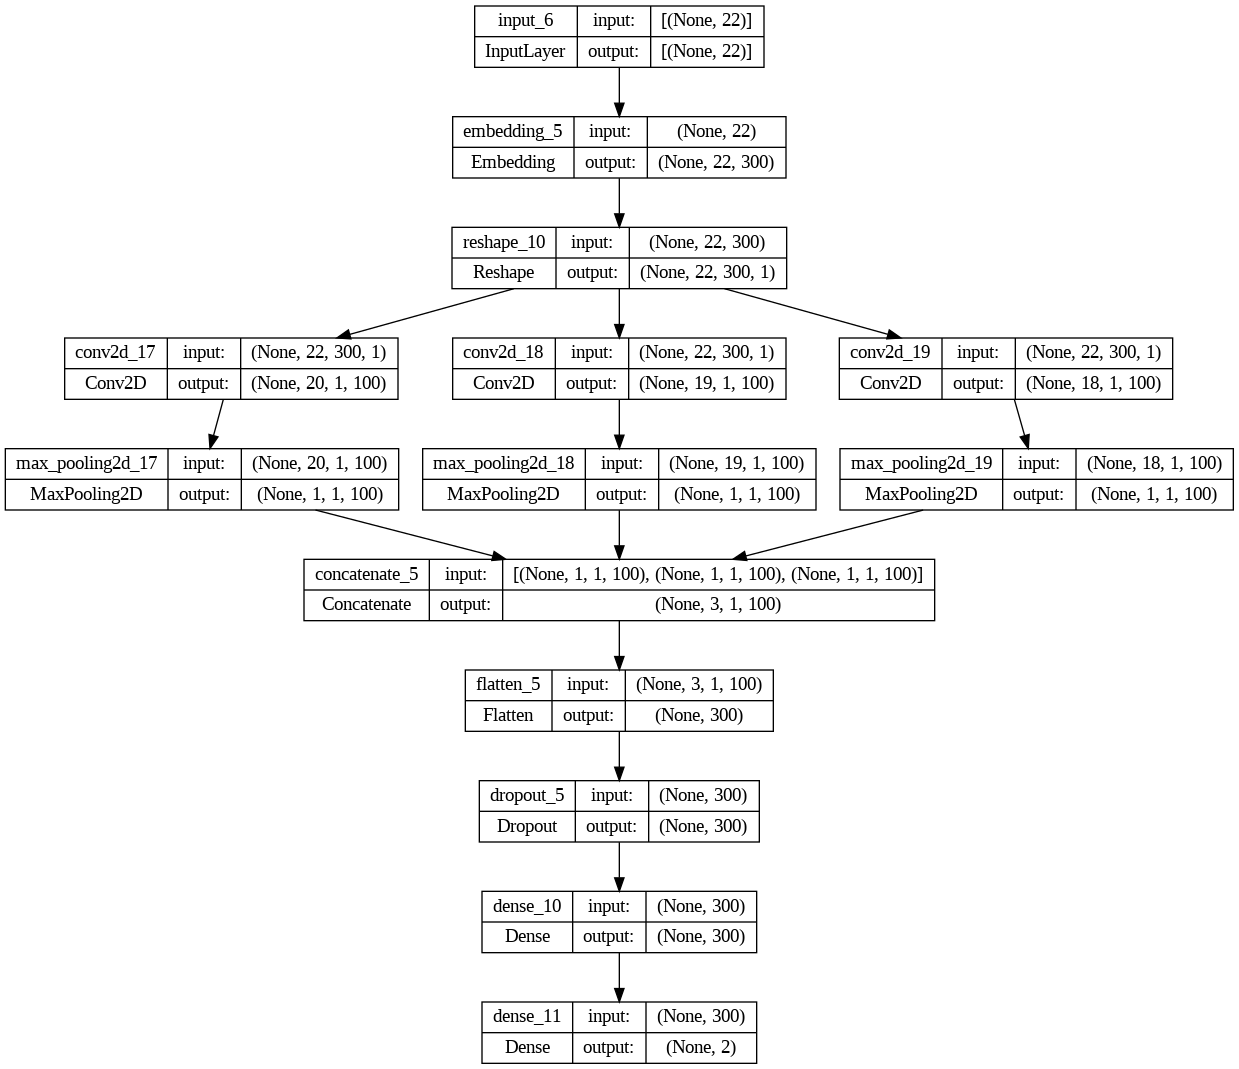

In [ ]:


from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

sequence_length = X_train_multilabel.shape[1]
filter_sizes = [3,4,5] # filter sizes for the convolutions
num_filters = 100 # number of filters for each convolution
drop = 0.5 # dropout rate

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# added two new layers
# conv_3 = Conv2D(num_filters, (filter_sizes[3], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# conv_4 = Conv2D(num_filters, (filter_sizes[4], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)
# added two new layers
# maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[3] + 1, 1), strides=(1,1))(conv_3)
# maxpool_4 = MaxPooling2D((sequence_length - filter_sizes[4] + 1, 1), strides=(1,1))(conv_4)


# add maxpool_3 and maxpool_4 here if using 5 channels instead of 3
merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
# change 3 to 5 if using 5 channels
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
# change the first parameter to len(filter_sizes) * num_filters
Dense1 = Dense(300, activation='relu')(dropout)

output = Dense(units=2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(Dense1)

# this creates a model that includes
model_multilabel = Model(inputs, output)

# change learning rate if need be
adam = Adam(learning_rate=1e-4)

model_multilabel.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])

from keras.utils.vis_utils import plot_model

plot_model(model_multilabel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



Train multilabel classification model

Epoch 1/15
482/482 [==============================] - 77s 158ms/step - loss: 0.7166 - acc: 0.6491 - val_loss: 0.6855 - val_acc: 0.6596
Epoch 2/15
482/482 [==============================] - 75s 155ms/step - loss: 0.6745 - acc: 0.6503 - val_loss: 0.6709 - val_acc: 0.6596
Epoch 3/15
482/482 [==============================] - 75s 156ms/step - loss: 0.6511 - acc: 0.6574 - val_loss: 0.6745 - val_acc: 0.6546
Epoch 4/15
482/482 [==============================] - 72s 150ms/step - loss: 0.6107 - acc: 0.7132 - val_loss: 0.6848 - val_acc: 0.6681
Epoch 5/15
482/482 [==============================] - 72s 150ms/step - loss: 0.5436 - acc: 0.7778 - val_loss: 0.7202 - val_acc: 0.6772
Epoch 6/15
482/482 [==============================] - 75s 155ms/step - loss: 0.4768 - acc: 0.8299 - val_loss: 0.7888 - val_acc: 0.6843
Epoch 7/15
482/482 [==============================] - 74s 153ms/step - loss: 0.4184 - acc: 0.8664 - val_loss: 0.8073 - val_acc: 0.6853
Epoch 8/15
482/482 [==============================] - 7

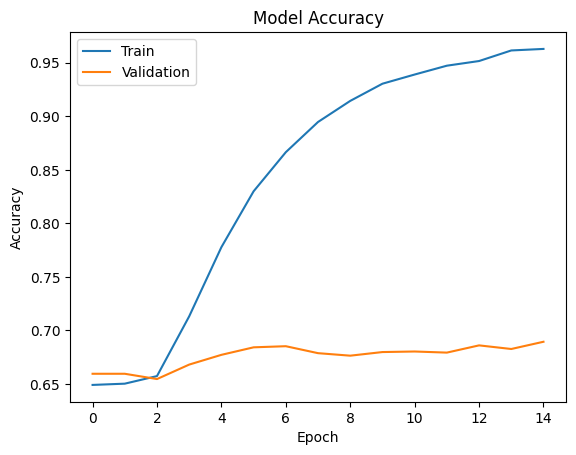

In [ ]:
import matplotlib.pyplot as plt
# here we can decide to use early stopping or not during training and change training parameters
callbacks = [EarlyStopping(monitor='val_loss')]
history = model_multilabel.fit(X_train_multilabel, y_train_multilabel, batch_size=32, epochs=15, verbose=1, validation_data=(X_val_multilabel, y_val_multilabel), callbacks=callbacks) 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Test for multilabel classification

151/151 [==============================] - 4s 26ms/step
(4811, 2)


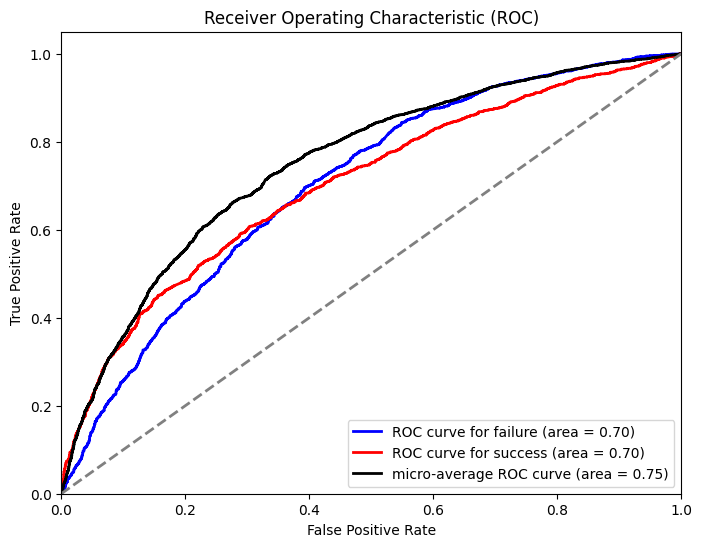

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import csv



# Get predicted probabilities from model
y_pred = model_multilabel.predict(X_test_multilabel)

# create a csv from the predictions
to_submit = pd.DataFrame(index=test_data_multilabel.view_score, data={'success':y_pred[:,dic['success']],
                                                  'failure':y_pred[:,dic['failure']]})
to_submit.to_csv('submit_multilabel.csv')

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(targets)):
    fpr[i], tpr[i], _ = roc_curve(y_test_multilabel[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_multilabel.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple']  # adjust colors as needed
for i, target in enumerate(targets):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw,
             label='ROC curve for {0} (area = {1:0.2f})'.format(target, roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='black', lw=lw,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro))
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import csv
import numpy as np

# get the results from the csv created from the predicitions
test_results = open('submit_multilabel.csv', mode='r')
reader = csv.DictReader(test_results)

debug = 0
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
y_predictions = []

# calculate tp, fp, fn, tn for confusion matrix

# use this for second classifier
# for row in reader:
#   if(float(row["view_score"]) >= 1 and float(row["success"]) > float(row["failure"])):
#     true_positive += 1
#     y_predictions.append("success")
#   elif(float(row["view_score"]) < 1 and float(row["success"]) > float(row["failure"])):
#     false_positive += 1
#     y_predictions.append("success")
#   elif(float(row["view_score"]) < 1 and float(row["failure"]) > float(row["success"])):
#     true_negative += 1
#     y_predictions.append("failure")
#   elif(float(row["view_score"]) >= 1 and float(row["failure"]) > float(row["success"])):
#     false_negative += 1
#     y_predictions.append("failure")
#   else:
#     print(float(row["view_score"]), float(row["success"]), float(row["failure"]))

# use this for first classifier
for row in reader:
  if(int(row["view"]) > 392000 and float(row["success"]) > float(row["failure"])):
    true_positive += 1
    y_predictions.append("success")
  elif(int(row["view"]) < 392000 and float(row["success"]) > float(row["failure"])):
    false_positive += 1
    y_predictions.append("success")
  elif(int(row["view"]) < 392000 and float(row["failure"]) > float(row["success"])):
    true_negative += 1
    y_predictions.append("failure")
  elif(int(row["view"]) >= 392000 and float(row["failure"]) > float(row["success"])):
    false_negative += 1
    y_predictions.append("failure")
  else:
    print(int(row["view"]), float(row["success"]), float(row["failure"]))


print("true positives", true_positive)
print("false positives", false_positive)
print("false negatives", false_negative)
print("true negatives", true_negative)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions)
plt.show()

# calculate accuracy, precision, recall, and f1 score
test_accuracy = (true_positive + true_negative) / (false_negative + false_positive + true_positive + true_negative)
test_precision = true_positive / (true_positive + false_positive)
test_recall = true_positive / (true_positive + false_negative)
f1_score = 2 * ((test_precision * test_recall) / (test_precision + test_recall))
print('test accuracy: ', test_accuracy)
print('test precision: ', test_precision)
print('test recall: ', test_recall)
print('f1 score: ', f1_score)